In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110
'''!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz'''

'!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz\n!gunzip -k methane.extxyz.gz'

In [2]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
from torch import nn
import sys
sys.path.append('./code/')
from code_pytorch import *
from utilities import *

In [3]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
train_subset = '0:10000'
test_subset = '10000:11000'
DEVICE = 'cuda'
MAGIC_NUMBER = 1
FIRST_BATCH_NORM_EPSILON = 1e-20 #spherical expansion coefficients from rascal might be really small!

In [4]:
train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species, split_by_central_specie = False)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species, split_by_central_specie = False)


train_coefficients *= MAGIC_NUMBER
test_coefficients *= MAGIC_NUMBER
print(train_coefficients.shape)
print(test_coefficients.shape)

100%|██████████| 10/10 [00:00<00:00, 153.65it/s]

(50000, 10, 6, 11)
(5000, 10, 6, 11)


In [5]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

train_energies = torch.FloatTensor(train_energies).to(DEVICE)
test_energies = torch.FloatTensor(test_energies).to(DEVICE)

train_forces = [structure.arrays["forces"] for structure in train_structures]
train_forces = np.concatenate(train_forces, axis = 0) * FORCE_FACTOR

test_forces = [structure.arrays["forces"] for structure in test_structures]
test_forces = np.concatenate(test_forces, axis = 0) * FORCE_FACTOR


coef_der_train, central_indices_train, derivative_indices_train = \
get_coef_ders(train_structures, HYPERS, all_species)
print(np.min(derivative_indices_train[0:12500]))
print(np.max(derivative_indices_train[0:12500]))
print(np.min(central_indices_train[0:12500]))
print(np.max(central_indices_train[0:12500]))

for key in coef_der_train.keys():
    coef_der_train[key] = torch.from_numpy(coef_der_train[key])\
    .type(torch.get_default_dtype()).to(DEVICE) * MAGIC_NUMBER

    
coef_der_test, central_indices_test, derivative_indices_test = \
get_coef_ders(test_structures, HYPERS, all_species)


for key in coef_der_test.keys():
    coef_der_test[key] = torch.from_numpy(coef_der_test[key])\
    .type(torch.get_default_dtype()).to(DEVICE) * MAGIC_NUMBER

0
2499
0
2499


In [6]:
def convert_to_torch(coefficients):
    result = {}
    for lambd in range(coefficients.shape[2]):
        result[lambd] = torch.FloatTensor(coefficients[:, :, lambd, : 2 * lambd + 1])        
    return result

train_coefficients = convert_to_torch(train_coefficients)
test_coefficients = convert_to_torch(test_coefficients)

for key in train_coefficients.keys():
    print(train_coefficients[key].shape)

torch.Size([50000, 10, 1])
torch.Size([50000, 10, 3])
torch.Size([50000, 10, 5])
torch.Size([50000, 10, 7])
torch.Size([50000, 10, 9])
torch.Size([50000, 10, 11])


In [7]:
def get_loss(predictions, targets):
    delta = predictions - targets
    return torch.mean(delta * delta)

def get_mae(first, second):
    return np.mean(np.abs(first - second))

def get_rmse(first, second):
    delta = first - second
    return np.sqrt(np.mean(delta * delta))

class Model(torch.nn.Module):
    def __init__(self, input_lambda_max):
        super(Model, self).__init__()
        clebsch = nice.clebsch_gordan.ClebschGordan(input_lambda_max)
        self.clebsch_combining = ClebschCombining(clebsch.precomputed_, 0)
        self.sequential = nn.Sequential(nn.BatchNorm1d(600, eps = FIRST_BATCH_NORM_EPSILON), nn.Linear(600, 200), nn.BatchNorm1d(200), nn.Tanh(),
                                        nn.Linear(200, 200), nn.BatchNorm1d(200), nn.Tanh(),
                                        nn.Linear(200, 1))
        
    def forward(self, X):
        X = self.clebsch_combining(X, X)[0].squeeze()        
        return {'predictions' : self.sequential(X).squeeze()}

In [8]:
model = Model(LAMBDA_MAX)
result = model(train_coefficients)
print(type(result))
print(result['predictions'].shape)

<class 'dict'>
torch.Size([50000])


In [9]:
models = {}
for key in all_species:
    models[str(key)] = Model(LAMBDA_MAX)
    

In [10]:
atomistic = Atomistic(models).to(DEVICE)
optim = torch.optim.Adam(atomistic.parameters())




train_struc = {'energies' : train_energies}
test_struc = {'energies' : test_energies}
#print(train_atomic[0].device)
#print(torch.is_tensor(train_atomic[0]))
BATCH_SIZE = 500
history = {'train_mae' : [], 'test_mae' : [],
           'train_rmse' : [], 'test_rmse' : []}
for epoch_num in range(100):
    train_predictions = []
    atomistic.train(True)
    for _, _, _, coef_batch, structural_batch, structures_batch in iterate_minibatches(None, None, None, train_coefficients, train_struc,
                                                  train_structures, BATCH_SIZE, DEVICE):
        energies_now = structural_batch['energies']
       
        predictions = atomistic(coef_batch, structures_batch)['predictions'].squeeze()
        train_predictions.append(predictions.data.cpu().numpy())       
        loss = get_loss(predictions, energies_now)
        loss.backward()
        optim.step()
        optim.zero_grad()
    atomistic.train(False)
    train_predictions = np.concatenate(train_predictions, axis = 0)
    train_mae = get_mae(train_predictions, train_energies.data.cpu().numpy())
    train_rmse = get_rmse(train_predictions, train_energies.data.cpu().numpy())
    if epoch_num % 10 == 0:
        print("train mae: ", train_mae)
        print("train rmse: ", train_rmse)
        
    test_predictions = []
    for _, _, _, coef_batch, structural_batch, structures_batch in iterate_minibatches(None, None, None, test_coefficients, test_struc,
                                                   test_structures, BATCH_SIZE, DEVICE):
        
        energies_now = structural_batch['energies']
        predictions = atomistic(coef_batch, structures_batch)['predictions'].squeeze()
        test_predictions.append(predictions.data.cpu().numpy())
    test_predictions = np.concatenate(test_predictions, axis = 0)
    test_mae = get_mae(test_predictions, test_energies.data.cpu().numpy())
    test_rmse = get_rmse(test_predictions, test_energies.data.cpu().numpy())
    if epoch_num % 10 == 0:
        print("test mae: ", test_mae)
        print("test rmse: ", test_rmse)
    history['train_mae'].append(train_mae)
    history['test_mae'].append(test_mae)
    history['train_rmse'].append(train_rmse)
    history['test_rmse'].append(test_rmse)

train mae:  1.1655603108145232
train rmse:  1.8896581515251676
test mae:  2.197414499728713
test rmse:  3.50537499508842
train mae:  0.26311277993046667
train rmse:  0.36334181301338764
test mae:  2.549471739565889
test rmse:  3.9216425126287504
train mae:  0.30925390364460703
train rmse:  0.42343685212989773
test mae:  1.3048296634274252
test rmse:  1.7592668684236172
train mae:  0.2573692318992271
train rmse:  0.3433288117210309
test mae:  0.2946264562145419
test rmse:  0.4377907560466951
train mae:  0.1877547376982925
train rmse:  0.24433470831462573
test mae:  0.29960335230122553
test rmse:  0.41455701473637563
train mae:  0.2839151594953074
train rmse:  0.36333778606929706
test mae:  0.2536603155585272
test rmse:  0.37361408158041576
train mae:  0.16329706395352545
train rmse:  0.2121969377300555
test mae:  0.19705938537297074
test rmse:  0.3186553237146801
train mae:  0.17654986859504423
train rmse:  0.2422221827212775
test mae:  0.21813449477503769
test rmse:  0.3276538376845542

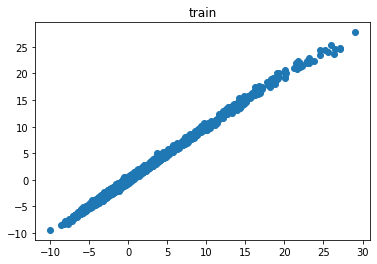

train rmse 0.20770808617638067
train mae:  0.1543317050295843


In [11]:
plt.plot(train_energies.data.cpu().numpy(), train_predictions, 'o')
plt.title("train")
plt.show()
print("train rmse", get_rmse(train_energies.data.cpu().numpy(), train_predictions))
print("train mae: ", get_mae(train_energies.data.cpu().numpy(), train_predictions))



test rmse 0.34218898180289026
test mae:  0.22279230601494537


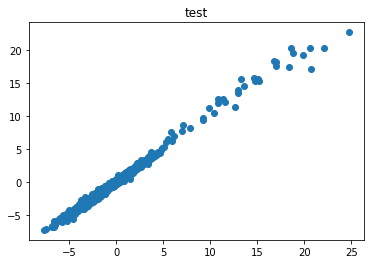

In [12]:
plt.plot(test_energies.data.cpu().numpy(), test_predictions, 'o')
plt.title("test")

print("test rmse", get_rmse(test_energies.data.cpu().numpy(), test_predictions))
print("test mae: ", get_mae(test_energies.data.cpu().numpy(), test_predictions))
plt.show()

In [13]:
atomistic = atomistic.train(False)
print(np.min(derivative_indices_train[0:12500]))
print(np.max(derivative_indices_train[0:12500]))

0
2499


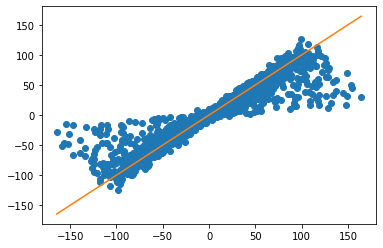

train mae:  0.5099954648277266
train rmse:  2.475887254365614


In [14]:
forces_predictions_train = []
for key in train_coefficients.keys():
    train_coefficients[key].requires_grad = True
for coef_der_batch, central_batch, derivative_batch, coef_batch, _, structures_batch in iterate_minibatches(coef_der_train,
                                                    central_indices_train, derivative_indices_train, train_coefficients, None,
                                                   train_structures, BATCH_SIZE, DEVICE):
    forces_predictions_now = atomistic.get_forces(coef_batch, structures_batch, 
                                          coef_der_batch, central_batch, derivative_batch)
    #print(forces_predictions_now.shape)
    forces_predictions_train.append(forces_predictions_now)
    
forces_predictions_train = torch.cat(forces_predictions_train, dim = 0)
forces_predictions_a = forces_predictions_train.data.cpu().numpy().reshape([-1])
forces_a = train_forces.reshape([-1])
plt.plot(forces_a, forces_predictions_a, 'o')
plt.plot([np.min(forces_a), np.max(forces_a)],
         [np.min(forces_a), np.max(forces_a)])
plt.show()
print("train mae: ", get_mae(forces_a, forces_predictions_a))
print("train rmse: ", get_rmse(forces_a, forces_predictions_a))

torch.Size([2500, 3])
torch.Size([2500, 3])


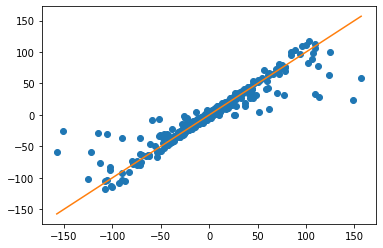

test mae:  0.5528029570486329
test rmse:  2.8871975145121263


In [15]:
forces_predictions_test = []
for key in test_coefficients.keys():
    test_coefficients[key].requires_grad = True
    
for coef_der_batch, central_batch, derivative_batch, coef_batch, _, structures_batch in iterate_minibatches(coef_der_test,
                                                    central_indices_test, derivative_indices_test, test_coefficients, None,
                                                   test_structures, BATCH_SIZE, DEVICE):
    forces_predictions_now = atomistic.get_forces(coef_batch, structures_batch, 
                                          coef_der_batch, central_batch, derivative_batch)
    print(forces_predictions_now.shape)
    forces_predictions_test.append(forces_predictions_now)
    
forces_predictions_test = torch.cat(forces_predictions_test, dim = 0)
forces_predictions_a = forces_predictions_test.data.cpu().numpy().reshape([-1])
forces_a = test_forces.reshape([-1])
plt.plot(forces_a, forces_predictions_a, 'o')
plt.plot([np.min(forces_a), np.max(forces_a)],
         [np.min(forces_a), np.max(forces_a)])

plt.show()
print("test mae: ", get_mae(forces_a, forces_predictions_a))
print("test rmse: ", get_rmse(forces_a, forces_predictions_a))